In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import pickle
import numpy as np 

from sklearn.model_selection import train_test_split

import keras
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50


import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt 


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)


In [4]:
x_train = np.load('x_train.npy').astype('float32') / 255.
x_cv = np.load('x_cv.npy').astype('float32') / 255.

y_train = np.load('y_train.npy')
y_cv = np.load('y_cv.npy')

x_train.shape, x_cv.shape, y_train.shape, y_cv.shape

((74708, 64, 64, 3), (18677, 64, 64, 3), (74708, 1), (18677, 1))

In [5]:
X_train_flattened = x_train.reshape(-1, 64*64*3)
X_cv_flattened = x_cv.reshape(-1, 64*64*3)

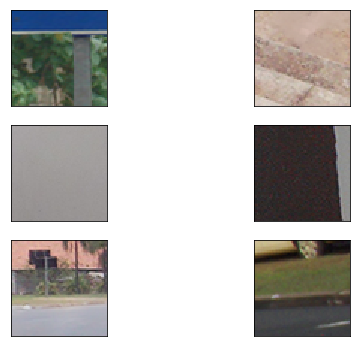

In [6]:
fig = plt.figure(figsize = (8, 6))
for i in range(6):
  ax = fig.add_subplot(3, 2, i + 1, xticks = [], yticks = [])
  ax.imshow(x_train[i])

In [21]:
num_features = X_train_flattened.shape[1]
print("Number of features: {}".format(num_features))

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers



# this is the size of our encoded representations
encoding_dim = 100  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

#initializer = keras.initializers.glorot_normal(seed=None)

# this is our input placeholder
input_img = Input(shape=(num_features,))
# "encoded" is the encoded representation of the input
x = Dense(8000, activation = 'relu')(input_img)
x = Dense(4000, activation = 'relu')(x)
x = Dense(2000, activation = 'relu')(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(500, activation = 'relu')(x)
x = Dense(250, activation = 'relu')(x)
encoded = Dense(encoding_dim, activation='relu')(x)#, activity_regularizer=regularizers.l1(10e-5))(x)
x = Dense(250, activation = 'relu')(encoded)
x = Dense(500, activation = 'relu')(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(2000, activation = 'relu')(x)
x = Dense(4000, activation = 'relu')(x)
x = Dense(8000, activation = 'relu')(x)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(num_features, activation='sigmoid')(x)#, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model

adam = keras.optimizers.Adam(lr=0.01, decay=1e-5)
#sgd = keras.optimizers.SGD(lr=0.01, momentum=0.8, decay=1e-2, nesterov=False)

autoencoder.compile(optimizer=adam, loss='binary_crossentropy')



Number of features: 12288


In [22]:
from keras.callbacks import TensorBoard

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt 

#earlystopper = EarlyStopping(patience=3, verbose=1) 
#checkpointer = ModelCheckpoint(path + 'autoencoder.h5', verbose=1, save_best_only=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

class ImageSaver(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        pass
 
    def on_epoch_begin(self, epoch, logs={}):
        if epoch % 5 == 0:
            #encoded_imgs = encoder.predict(X_cv_flattened[0:2])
            #decoded_imgs = decoder.predict(encoded_imgs)
            decoded_imgs = autoencoder.predict(X_cv_flattened[0:2])
            
            plt.imsave('img/track_1_%d.png' % (epoch), decoded_imgs[0].reshape(64, 64, 3))
            plt.imsave('img/track_2_%d.png' % (epoch), decoded_imgs[1].reshape(64, 64, 3))
            
        #logging.info("Epoch: {}".format(epoch))

        
autoencoder.fit(X_train_flattened, X_train_flattened,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(X_cv_flattened, X_cv_flattened),
                callbacks=[ImageSaver()])

Train on 74708 samples, validate on 18677 samples
Epoch 1/100


ResourceExhaustedError: OOM when allocating tensor with shape[4000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training_7/Adam/Variable_31/Assign (defined at /home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:402)  = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_7/Adam/Variable_31, dense_46/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_7/Adam/Variable_31/Assign', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-be263c2a9f0e>", line 33, in <module>
    callbacks=[ImageSaver()])
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/engine/training.py", line 1010, in fit
    self._make_train_function()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/optimizers.py", line 488, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/optimizers.py", line 488, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 704, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 1481, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/state_ops.py", line 221, in assign
    validate_shape=validate_shape)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 61, in assign
    use_locking=use_locking, name=name)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[4000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training_7/Adam/Variable_31/Assign (defined at /home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:402)  = Assign[T=DT_FLOAT, _grappler_relax_allocator_constraints=true, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_7/Adam/Variable_31, dense_46/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

